In [1]:
import os
from google.colab import drive
drive_path = "/content/drive"
drive.mount(drive_path)

Mounted at /content/drive


Path of the source file to access python modules.

In [2]:
project_path_rel = "MyDrive/desktop/new_academia/ML_DS_Statistics/YOLO_TF/"
project_path = os.path.join(drive_path, project_path_rel)

In [3]:
! cp -r {project_path}* ./

Import necessary python packages

In [4]:
def find_device(prior="GPU"):
  for my_device in tf.config.list_logical_devices():
    if my_device.device_type == prior:
      return my_device.name

In [5]:
# Generic python packages
import numpy as np
import gc
import json
import cv2
import skimage.io as io
import matplotlib.pyplot as plt
import seaborn as sns
import random

# TF-related packages
import tensorflow as tf
from tensorflow import keras

# local packages
from src import (dataParser as dp, 
                 dataLoader as dl,
                 obj_det_model,
                 utils)

# Device on which training to be done
DEVICE = find_device()

# PRECISION to be used for weights of model
PRECISION = tf.float32

In [6]:
DEVICE

'/device:GPU:0'

Load Raw data from the desired dataset

In [7]:
# VOC
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar xvf ./VOCtrainval_11-May-2012.tar

# # COCO
# !unzip "/content/drive/MyDrive/ML_DS_Statistics/Dataset/coco/annotations_trainval2017.zip" -d .
# !unzip "/content/drive/MyDrive/ML_DS_Statistics/Dataset/coco/train2017.zip" -d .

# # BDD100K LABELS
# !unzip "/content/drive/MyDrive/ML_DS_Statistics/Dataset/bdd/bdd100k_det_20_labels_trainval.zip" -d .

# # BDD100K IMAGES
# !unzip "/content/drive/MyDrive/ML_DS_Statistics/Dataset/bdd/bdd100k_images_100k.zip" -d .

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2012/SegmentationClass/2008_001874.png
VOCdevkit/VOC2012/SegmentationClass/2008_001876.png
VOCdevkit/VOC2012/SegmentationClass/2008_001882.png
VOCdevkit/VOC2012/SegmentationClass/2008_001885.png
VOCdevkit/VOC2012/SegmentationClass/2008_001895.png
VOCdevkit/VOC2012/SegmentationClass/2008_001896.png
VOCdevkit/VOC2012/SegmentationClass/2008_001926.png
VOCdevkit/VOC2012/SegmentationClass/2008_001966.png
VOCdevkit/VOC2012/SegmentationClass/2008_001971.png
VOCdevkit/VOC2012/SegmentationClass/2008_001992.png
VOCdevkit/VOC2012/SegmentationClass/2008_001997.png
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC

Parse the raw data into desired format

We will parse all the individual images into following formats.

Each image:
```
image = {
          'file': {NAME_OF_FILE},
          'height': {HEIGHT_OF_IMAGE},
          'width': {WIDTH_OF_IMAGE},
          'objects: [{'bbox':[x_min,y_min,b_width,b_height], 'name': {LABEL_OF_OBJECT} }, ...]
        }
```

Entire dataset will be python list of these dictionaries<

In [8]:
# Parse annotations 
train_image_folder = "VOCdevkit/VOC2012/JPEGImages/"
train_annot_folder = "VOCdevkit/VOC2012/Annotations/"

ANCHORS = np.array([1.07709888,  1.78171903,  # anchor box 1, width , height
                    2.71054693,  5.12469308,  # anchor box 2, width,  height
                   10.47181473, 10.09646365,  # anchor box 3, width,  height
                    5.48531347,  8.11011331]) # anchor box 4, width,  height

# Name of the labels in VOC
LABELS_VOC = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
              'bus',        'car',      'cat',  'chair',     'cow',
              'diningtable','dog',    'horse',  'motorbike', 'person',
              'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

for idx, label in enumerate(LABELS_VOC):
  LABELS_VOC[idx] = dp.cat_name_COCO_to_VOC(label)

train_image_voc = dp.parse_annotation_VOC(train_annot_folder,train_image_folder, labels=LABELS_VOC)

train_image = train_image_voc
LABELS = LABELS_VOC

_ANCHORS01 = np.array([0.19, 0.40,
                       0.79, 0.74,
                       0.086, 0.12,
                       0.41, 0.59])

In [9]:
# dataDir='.'
# dataType='train2017'
# annFile=f"{dataDir}/annotations/instances_{dataType}.json"

# my_json = json.load(open(annFile, 'r'))
# id_to_image = dp.COCO_json_img(my_json)
# id_to_cat = dp.COCO_json_cat(my_json)
# id_to_image = dp.attach_objs(id_to_image, id_to_cat, my_json)

# LABELS_COCO = list(id_to_cat.values())
# train_image_coco = list(id_to_image.values())


# train_image = train_image_coco
# LABELS = LABELS_COCO


# _ANCHORS01 = np.array([0.22905231, 0.327348,
#                       0.0601304 , 0.07305195,
#                       0.02738149, 0.05411568,
#                       0.01381426, 0.02333195,
#                       0.15897478, 0.17922826,
#                       0.36362706, 0.53264426,
#                       0.08428863, 0.14411576,
#                       0.1, 0.03])
# del my_json #, id_to_image
# gc.collect()

# for coco_img in train_image:
#   coco_img["file"] = os.path.join("train2017", os.path.basename(coco_img["file"]))

In [10]:
# dataDir='./bdd100k'
# dataType='train'
# img_folder = './bdd100k/images/100k/train/'
# annFile=f"{dataDir}/labels/det_20/det_{dataType}.json"
# # Name of the labels in VOC
# LABELS_BDD = ['pedestrian', 'rider', 'car', 'truck', 'bus',
#               'train', 'motorcycle', 'bicycle', 'traffic light', 'traffic sign']

# my_json = json.load(open(annFile, 'r'))

# train_image_bdd = dp.bdd_to_format(my_json, img_folder, is_attributes=False)


In [11]:
GRID_H,  GRID_W  = 13 , 13
ANCHORS          = _ANCHORS01.astype(np.single)
ANCHORS[::2]     = ANCHORS[::2]*GRID_W  
ANCHORS[1::2]    = ANCHORS[1::2]*GRID_H  
ANCHORS

array([ 2.47     ,  5.2000003, 10.27     ,  9.62     ,  1.118    ,
        1.56     ,  5.33     ,  7.6699996], dtype=float32)

In [12]:
IMAGE_H, IMAGE_W = 416, 416
BATCH_SIZE       = 16
BOX = int(len(ANCHORS)/2)
CLASS = len(LABELS)

obj_det_config = {
    'image_h'         : IMAGE_H, 
    'image_w'         : IMAGE_W,
    'grid_h'          : GRID_H,  
    'grid_w'          : GRID_W,
    'box'             : BOX,
    'classes'          : LABELS,
    'anchors'         : ANCHORS,
    'batch_size'      : BATCH_SIZE,
}

shuffle = True

random.seed(43)
# Shuffle the data before loading
random.shuffle(train_image)
split = int(len(train_image) * 0.85)

train_batch_generator = dl.YOLOData(train_image[:split], obj_det_config,
                                        norm=True, shuffle=shuffle)

val_batch_generator = dl.YOLOData(train_image[split:], obj_det_config,
                                        norm=True, shuffle=False)

In [13]:
x_batch, y_batch = train_batch_generator.__getitem__(idx=0)
print(f"x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = {x_batch.shape}")
print(f"y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = {y_batch.shape}")

x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = (16, 416, 416, 3)
y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = (16, 13, 13, 4, 6)


In [14]:
iframe= 1
def check_object_in_grid_anchor_pair(irow):
    for igrid_h in range(obj_det_config["grid_h"]):
        for igrid_w in range(obj_det_config["grid_w"]):
            for ianchor in range(obj_det_config["box"]):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] # ground truth confidence
                if C == 1:
                    classes = vec[5:6].astype(int)
                    class_nm = np.array(LABELS)[classes]
                    print(class_nm, igrid_h, igrid_w, ianchor)
                    assert len(class_nm) == 1
                    print(f"igrid_h={igrid_h:02.0f},igrid_w={igrid_w:02.0f},iAnchor={ianchor:02.0f}, {class_nm[0]}")
check_object_in_grid_anchor_pair(iframe)

['cat'] 5 4 1
igrid_h=05,igrid_w=04,iAnchor=01, cat


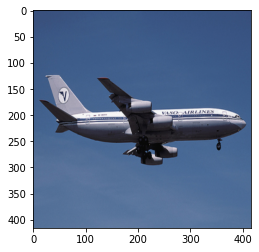

In [15]:
plt.imshow(x_batch[0])

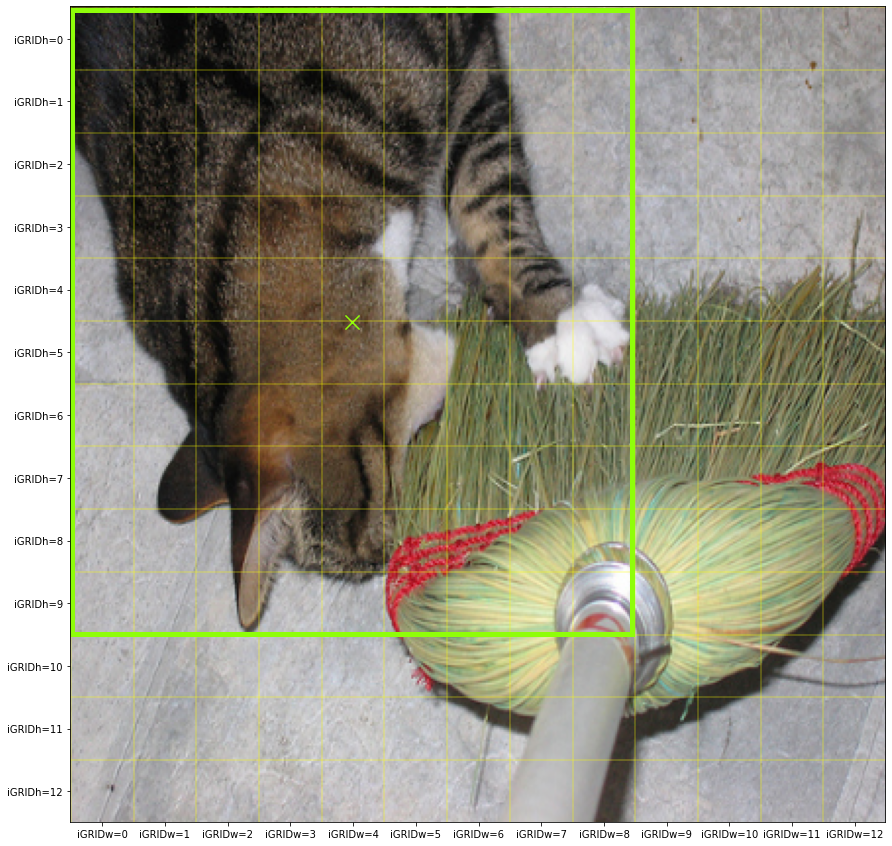

In [16]:
def plot_image_with_grid_cell_partition(irow):
    img = x_batch[irow]
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    for wh in ["w","h"]:
        GRID_       = obj_det_config["grid_"  + wh] ## 13
        IMAGE_      = obj_det_config["image_" + wh] ## 416
        if wh == "w":
            pltax   = plt.axvline
            plttick = plt.xticks
        else:
            pltax   = plt.axhline
            plttick = plt.yticks
            
        for count in range(GRID_):
            l = IMAGE_*count/GRID_
            pltax(l,color="yellow",alpha=0.3) 
        plttick([(i + 0.5)*IMAGE_/GRID_ for i in range(GRID_)],
                [f"iGRID{wh}={i}" for i in range(GRID_)])

def plot_grid(irow):
    color_palette = list(sns.xkcd_rgb.values())
    iobj = 0
    for igrid_h in range(obj_det_config["grid_h"]):
        for igrid_w in range(obj_det_config["grid_w"]):
            for ianchor in range(obj_det_config["box"]):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] ## ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    x_o, y_o, w, h = vec[:4]
                    multx = obj_det_config["image_w"]/obj_det_config["grid_w"]
                    multy = obj_det_config["image_h"]/obj_det_config["grid_h"]
                    c = color_palette[iobj]
                    iobj += 1
                    x = x_o
                    y = y_o
                    xmin = x - 0.5*w 
                    ymin = y - 0.5*h
                    xmax = x + 0.5*w
                    ymax = y + 0.5*h  
                    # center
                    plt.scatter(x*multx,y*multy,
                             marker='x',color=c,s=200)
                    plt.plot(np.array([xmin,xmin])*multx,
                             np.array([ymin,ymax])*multy,color=c,linewidth=5)
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymin,ymin])*multy,color=c,linewidth=5)
                    plt.plot(np.array([xmax,xmax])*multx,
                             np.array([ymax,ymin])*multy,color=c,linewidth=5)  
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymax,ymax])*multy,color=c,linewidth=5)

plot_image_with_grid_cell_partition(iframe)
plot_grid(iframe)
plt.show()

In [17]:
for irow in range(5, 10):
    print("-"*30)
    check_object_in_grid_anchor_pair(irow)
    plot_image_with_grid_cell_partition(irow)
    plot_grid(irow)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Neural Network Model

In [18]:
myVGG = obj_det_model.VGGYOLO(CLASS=len(LABELS), BOX=len(_ANCHORS01)//2)

In [19]:
myVGG.summary(line_length=120)

Model: "VGGYOLO"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 input_1 (InputLayer)                  [(None, 416, 416, 3)]      0             []                                      
                                                                                                                        
 conv_1 (Conv2D)                       (None, 416, 416, 32)       864           ['input_1[0][0]']                       
                                                                                                                        
 norm_1 (BatchNormalization)           (None, 416, 416, 32)       128           ['conv_1[0][0]']                        
                                                                                                                        
 leaky_re_lu (L

Load weights from yolov2 paper

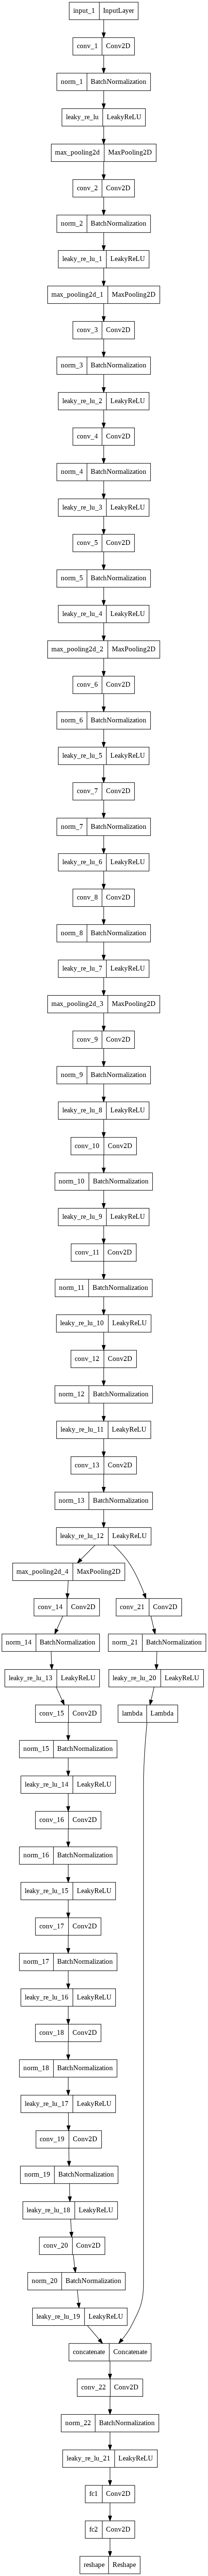

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(myVGG)

In [21]:
!wget https://pjreddie.com/media/files/yolov2.weights

--2022-05-02 13:03:24--  https://pjreddie.com/media/files/yolov2.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203934260 (194M) [application/octet-stream]
Saving to: ‘yolov2.weights’

yolov2.weights      100%[===================>] 194.49M  18.7MB/s    in 11s     

2022-05-02 13:03:36 (17.1 MB/s) - ‘yolov2.weights’ saved [203934260/203934260]



In [22]:
path_to_weight = "./yolov2.weights"
weight_reader = obj_det_model.WeightReaderDarkNet19(path_to_weight)
print(f"all_weights.shape = {weight_reader.all_weights.shape}")

all_weights.shape = (50983565,)


In [23]:
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv):
    conv_layer = myVGG.get_layer('conv_' + str(i))
    
    if i < nb_conv:
        norm_layer = myVGG.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])



for i in range(2):  
  layer   = myVGG.layers[-(i+2)] # the last convolutional layer
  weights = layer.get_weights()

  new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
  new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

  layer.set_weights([new_kernel, new_bias])

In [24]:
def print_min_max(vec,title):
  try:
    print(f"{title} MIN={np.min(vec):5.2f}, MAX={np.max(vec):5.2f}")
  except ValueError:  #raised if `y` is empty.
      pass

Now, we go through some checks to make sure model outputs as intended

In [25]:
print("*"*30)
print("prepare inputs")
GRID_W = 13 
GRID_H = 13 
BOX    = int(len(ANCHORS)/2)
CLASS = len(LABELS)
size   = BATCH_SIZE*GRID_W*GRID_H*BOX*(4 + 1 + CLASS)
np.random.seed(42)
y_pred = np.random.normal(size=size,scale = 10/(GRID_H*GRID_W)).astype(np.single)
y_pred = y_pred.reshape(BATCH_SIZE,GRID_H,GRID_W,BOX,4 + 1 + CLASS)
print(f"y_pred before scaling = {y_pred.shape}")

print("*"*30)
print("define tensor graph")
y_pred_tf = tf.constant(y_pred,dtype="float32")
cell_grid = obj_det_model.get_cell_grid(GRID_W, GRID_H, BATCH_SIZE, BOX, DEVICE)
(pred_box_xy,   pred_box_wh, pred_box_conf, pred_box_class) = obj_det_model.yolo_head(y_pred_tf, 
                                                                ANCHORS)
print("*"*30 + "\nouput\n" + "*"*30) 

print(f"\npred_box_xy {pred_box_xy.shape}") 

for igrid_w in range(pred_box_xy.shape[2]):
        print_min_max(pred_box_xy[:,:,igrid_w,:,0],
                      f"  bounding box x at iGRID_W={igrid_w:02.0f}")
for igrid_h in range(pred_box_xy.shape[1]):
    print_min_max(pred_box_xy[:,igrid_h,:,:,1],
                  f"  bounding box y at iGRID_H={igrid_h:02.0f}")
    
print(f"\npred_box_wh {pred_box_wh.shape}")
print_min_max(pred_box_wh[:,:,:,:,0],"  bounding box width ") 
print_min_max(pred_box_wh[:,:,:,:,1],"  bounding box height") 
    
print(f"\npred_box_conf {pred_box_conf.shape}".format())
print_min_max(pred_box_conf,"  confidence ") 

print(f"\npred_box_class {pred_box_class.shape}")
print_min_max(pred_box_class,"  class probability") 

******************************
prepare inputs
y_pred before scaling = (16, 13, 13, 4, 25)
******************************
define tensor graph
******************************
ouput
******************************

pred_box_xy (16, 13, 13, 4, 2)
  bounding box x at iGRID_W=00 MIN= 0.46, MAX= 0.54
  bounding box x at iGRID_W=01 MIN= 1.45, MAX= 1.54
  bounding box x at iGRID_W=02 MIN= 2.45, MAX= 2.56
  bounding box x at iGRID_W=03 MIN= 3.45, MAX= 3.55
  bounding box x at iGRID_W=04 MIN= 4.44, MAX= 4.55
  bounding box x at iGRID_W=05 MIN= 5.45, MAX= 5.54
  bounding box x at iGRID_W=06 MIN= 6.46, MAX= 6.55
  bounding box x at iGRID_W=07 MIN= 7.44, MAX= 7.54
  bounding box x at iGRID_W=08 MIN= 8.45, MAX= 8.54
  bounding box x at iGRID_W=09 MIN= 9.45, MAX= 9.54
  bounding box x at iGRID_W=10 MIN=10.45, MAX=10.54
  bounding box x at iGRID_W=11 MIN=11.45, MAX=11.54
  bounding box x at iGRID_W=12 MIN=12.45, MAX=12.55
  bounding box y at iGRID_H=00 MIN= 0.45, MAX= 0.54
  bounding box y at iGRID_H=01 

In [26]:
def extract_ground_truth(y_true):    
    true_box_xy    = y_true[..., 0:2] # bounding box x, y coordinate in grid cell scale 
    true_box_wh    = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    true_box_conf  = y_true[...,4:5]    # confidence 
    true_box_class = tf.cast(y_true[...,5], tf.int32)
    return(true_box_xy, true_box_wh, true_box_conf, true_box_class)

In [27]:
# y_batch is the output of the simpleBatchGenerator.fit()
print(f"Input y_batch = {y_batch.shape}")

y_batch_tf = tf.constant(y_batch,dtype="float32")
(true_box_xy, true_box_wh, 
         true_box_conf, true_box_class) = extract_ground_truth(y_batch_tf)

print("*"*30 + "\nouput\n" + "*"*30) 

print(f"\ntrue_box_xy {true_box_xy.shape}")        
for igrid_w in range(true_box_xy.shape[2]):
    vec  = true_box_xy[:,:,igrid_w,:,0]
    pick = true_box_conf[:,:,igrid_w,:,0] == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],f"  bounding box x at iGRID_W={igrid_w:02.0f}")
    
for igrid_h in range(true_box_xy.shape[1]):
    vec  = true_box_xy[:,igrid_h,:,:,1]
    pick = true_box_conf[:,igrid_h,:,:,0] == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],f"  bounding box y at iGRID_H={igrid_h:02.0f}") 
    
print(f"\ntrue_box_wh {true_box_wh.shape}")
print_min_max(true_box_wh[:,:,:,:,0],"  bounding box width ") 
print_min_max(true_box_wh[:,:,:,:,1],"  bounding box height") 
    
print(f"\ntrue_box_conf {true_box_conf.shape}")
print(f"  confidence, unique value = {np.unique(true_box_conf)}") 

print(f"\ntrue_box_class {true_box_class.shape}")
print(f"  class index, unique value = {np.unique(true_box_class)}" )

Input y_batch = (16, 13, 13, 4, 6)
******************************
ouput
******************************

true_box_xy (16, 13, 13, 4, 2)
  bounding box x at iGRID_W=00 MIN= 0.29, MAX= 0.29
  bounding box x at iGRID_W=02 MIN= 2.00, MAX= 2.85
  bounding box x at iGRID_W=04 MIN= 4.30, MAX= 4.88
  bounding box x at iGRID_W=05 MIN= 5.34, MAX= 5.45
  bounding box x at iGRID_W=06 MIN= 6.14, MAX= 6.84
  bounding box x at iGRID_W=07 MIN= 7.15, MAX= 7.89
  bounding box x at iGRID_W=09 MIN= 9.58, MAX= 9.83
  bounding box x at iGRID_W=10 MIN=10.13, MAX=10.91
  bounding box x at iGRID_W=12 MIN=12.45, MAX=12.45
  bounding box y at iGRID_H=05 MIN= 5.01, MAX= 5.98
  bounding box y at iGRID_H=06 MIN= 6.11, MAX= 6.97
  bounding box y at iGRID_H=07 MIN= 7.01, MAX= 7.96
  bounding box y at iGRID_H=08 MIN= 8.09, MAX= 8.55
  bounding box y at iGRID_H=09 MIN= 9.05, MAX= 9.05
  bounding box y at iGRID_H=10 MIN=10.32, MAX=10.78
  bounding box y at iGRID_H=11 MIN=11.32, MAX=11.85

true_box_wh (16, 13, 13, 4, 2)
 

In [28]:
loss_xywh  = obj_det_model.yolo_coord_loss(pred_box_xy, pred_box_wh,
                                          true_box_xy, true_box_wh,
                                          true_box_conf)

print("*"*30 + "\nouput\n" + "*"*30)

print(f"loss_xywh = {loss_xywh/2:4.3f}")

******************************
ouput
******************************
loss_xywh = 4.970


In [29]:
loss_class  = obj_det_model.yolo_class_loss(pred_box_class, true_box_class, true_box_conf)
print("*"*30 + "\nouput\n" + "*"*30) 
print(f"loss_class = {loss_class:4.3f}")

******************************
ouput
******************************
loss_class = 3.010


******************************
input
******************************
true_box_conf = [[[[[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   ...

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]]


  [[[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   ...

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]]


  [[[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   ...

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]]


  ...


  [[[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   ...

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.

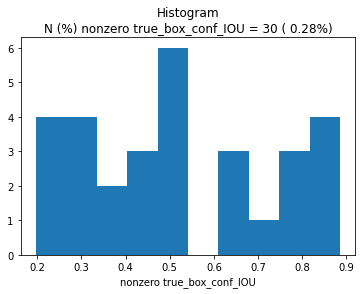

In [30]:
obj_mask_IOU = obj_det_model.obj_mask_iou(
                            true_box_conf,
                            pred_box_xy,  pred_box_wh,
                            true_box_xy, true_box_wh)

print("*"*30 + "\ninput\n" + "*"*30)    
print(f"true_box_conf = {true_box_conf}")
print(f"true_box_xy   = {true_box_xy}")
print(f"true_box_wh   = {true_box_wh}")
print(f"pred_box_xy   = {pred_box_xy}")
print(f"pred_box_wh   = {pred_box_wh}")
print("*"*30 + "\nouput\n" + "*"*30) 
print(f"true_box_conf_IOU.shape = {obj_mask_IOU.shape}")
vec  = obj_mask_IOU
pick = vec!=0
vec  = vec[pick]
plt.hist(vec)
plt.title(f"Histogram\nN (%) nonzero true_box_conf_IOU = {np.sum(pick)} ({100*np.mean(pick):5.2f}%)")
plt.xlabel("nonzero true_box_conf_IOU")
plt.show()

In [31]:
print("*"*30 + "\ninput\n" + "*"*30)    
print(f"true_box_wh   = {true_box_wh}")
print(f"pred_box_xy   = {pred_box_xy}")
print(f"pred_box_wh   = {pred_box_wh}")
print("*"*30 + "\nouput\n" + "*"*30) 


******************************
input
******************************
true_box_wh   = [[[[[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   ...

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]]


  [[[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   ...

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]]


  [[[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   ...

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
  

In [32]:
# Get confidence * iou values
lam_noobj = 1
lam_obj = 5
# get conf_mask

no_obj_mask_iou= (1-tf.squeeze(true_box_conf))
conf_mask = lam_noobj*no_obj_mask_iou + lam_obj*obj_mask_IOU

In [33]:

print("*"*30 + "\ninput\n" + "*"*30)  

print(f"true_box_conf     = {true_box_conf}")
print(f"true_box_conf_IOU = {obj_mask_IOU}")
print(f"LAMBDA_NO_OBJECT  = {lam_noobj}") 
print(f"LAMBDA_OBJECT     = {lam_obj}")

print("*"*30 + "\noutput\n" + "*"*30)      
print(f"conf_mask shape = {conf_mask.shape}")

******************************
input
******************************
true_box_conf     = [[[[[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   ...

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]]


  [[[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   ...

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]]


  [[[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   ...

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]]


  ...


  [[[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    [0.]]

   ...

   [[0.]
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
   

In [34]:
print("*"*30 + "\ninput\n" + "*"*30)  
print(f"pred_box_conf     = {pred_box_conf}")

loss_conf = obj_det_model.yolo_confidence_loss_bce_mask2(pred_box_conf, pred_box_xy, pred_box_wh, 
                                                    true_box_xy, true_box_wh,
                                                    true_box_conf,
                                                    lam_noobj=1, lam_obj=5)
    
print("*"*30 + "\noutput\n" + "*"*30)      
print(f"loss_conf = {loss_conf/2:5.8f}")

******************************
input
******************************
pred_box_conf     = [[[[-0.01385523 -0.01725999  0.06100589 -0.11760763]
   [-0.00954353 -0.02979146  0.01734157  0.16095676]
   [-0.0815189   0.04021288 -0.08990355 -0.02279962]
   ...
   [ 0.04131499 -0.06052027 -0.03256243  0.05030898]
   [ 0.06557295  0.0194534   0.09716066 -0.06530114]
   [ 0.00289113  0.13080017  0.07264314 -0.01829091]]

  [[ 0.03174615  0.03549874 -0.03411304  0.10804791]
   [ 0.05893773 -0.01637948  0.03346211 -0.02588511]
   [-0.0100701  -0.06624955 -0.01340112 -0.04794393]
   ...
   [ 0.11808684  0.05024273  0.07171267  0.01540121]
   [ 0.09902083 -0.01976788  0.04035811  0.0410011 ]
   [-0.06421009 -0.06691647 -0.05137827  0.10406038]]

  [[-0.03694351 -0.02837236 -0.03892512 -0.01558865]
   [ 0.01475199 -0.02871632 -0.0043756   0.02836932]
   [-0.00564877 -0.02168681  0.07206859 -0.01108456]
   ...
   [ 0.04627988 -0.03744113  0.00883808 -0.00495373]
   [-0.00830622 -0.13704993 -0.04096156

In [35]:
anchors_tf = tf.convert_to_tensor(ANCHORS)

In [36]:
anchors_tf.device

'/job:localhost/replica:0/task:0/device:GPU:0'

In [37]:
loss = obj_det_model.YoloLoss(anchors_tf, len(LABELS),
              w_coord=.5, w_class=1, w_conf=.5, lam_obj=5, lam_noobj=1,
              PRECISION = tf.float32, print_loss = False) 

In [38]:
print('loss', loss(y_true=tf.convert_to_tensor(y_batch, dtype=tf.float32), 
                        y_pred=y_pred_tf))

loss tf.Tensor(8.346749, shape=(), dtype=float32)


In [39]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

dir_log = "logs/"
try:
    os.makedirs(dir_log)
except:
    pass


obj_det_config['BATCH_SIZE'] = BATCH_SIZE

early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.0001, 
                           patience=2, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('./models/yolo_v2/weights_v1.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_freq="epoch")
with tf.device(DEVICE):
  optimizer = Adam(learning_rate=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  myVGG.compile(loss=loss ,optimizer=optimizer)

In [40]:
myVGG.fit(  x = train_batch_generator, 
            validation_data = val_batch_generator,
            steps_per_epoch  = len(train_batch_generator), 
            epochs           = 100, 
            verbose          = 1,
            callbacks        = [early_stop, ], 
            max_queue_size   = 3)

Epoch 1/100
910/910 [==============================] - 355s 370ms/step - loss: 0.5441 - val_loss: 0.2592
Epoch 2/100
910/910 [==============================] - 352s 387ms/step - loss: 0.2062 - val_loss: 0.2098
Epoch 3/100
910/910 [==============================] - 347s 381ms/step - loss: 0.1427 - val_loss: 0.1985
Epoch 4/100
910/910 [==============================] - 347s 381ms/step - loss: 0.1159 - val_loss: 0.2113
Epoch 5/100
910/910 [==============================] - 347s 381ms/step - loss: 0.0944 - val_loss: 0.2183
Epoch 5: early stopping


In [41]:
y_np = train_batch_generator[3][1][0][0]
x_np = train_batch_generator[3][0][0]

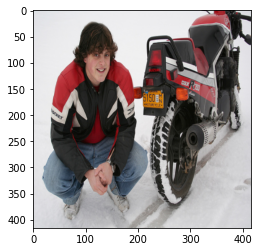

In [42]:
plt.imshow(x_np)

In [43]:
y_np.shape

(13, 4, 6)

In [44]:
print(x_np.shape)
X_test = np.expand_dims(x_np,0)
print(X_test.shape)

y_pred = myVGG(X_test)
print(y_pred.shape)

(416, 416, 3)
(1, 416, 416, 3)
(1, 13, 13, 4, 25)


In [45]:
def np_exp_threshold(x, threshold=10):
  mask = (x<=threshold)
  tens = np.exp(np.array([threshold/2]))-threshold
  return np.exp(x*mask)*mask + (x+tens)**2*(~mask)

In [46]:
class OutputRescaler(object):
    def __init__(self,ANCHORS):
        self.ANCHORS = ANCHORS

    def _sigmoid(self, x):
        return 1. / (1. + np.exp(-x))
    def _softmax(self, x, axis=-1, t=-100.):
        x = x - np.max(x)

        if np.min(x) < t:
            x = x/np.min(x)*t

        e_x = np.exp(x)
        return e_x / e_x.sum(axis, keepdims=True)
    def get_shifting_matrix(self,netout):
        
        GRID_H, GRID_W, BOX = netout.shape[:3]
        no = netout[...,0]
        
        ANCHORSw = self.ANCHORS[::2]
        ANCHORSh = self.ANCHORS[1::2]
       
        mat_GRID_W = np.zeros_like(no)
        for igrid_w in range(GRID_W):
            mat_GRID_W[:,igrid_w,:] = igrid_w

        mat_GRID_H = np.zeros_like(no)
        for igrid_h in range(GRID_H):
            mat_GRID_H[igrid_h,:,:] = igrid_h

        mat_ANCHOR_W = np.zeros_like(no)
        for ianchor in range(BOX):    
            mat_ANCHOR_W[:,:,ianchor] = ANCHORSw[ianchor]

        mat_ANCHOR_H = np.zeros_like(no) 
        for ianchor in range(BOX):    
            mat_ANCHOR_H[:,:,ianchor] = ANCHORSh[ianchor]
        return(mat_GRID_W,mat_GRID_H,mat_ANCHOR_W,mat_ANCHOR_H)

    def fit(self, netout):    
        '''
        netout  : np.array of shape (N grid h, N grid w, N anchor, 4 + 1 + N class)
        
        a single image output of model.predict()
        '''
        GRID_H, GRID_W, BOX = netout.shape[:3]
        
        (mat_GRID_W,
         mat_GRID_H,
         mat_ANCHOR_W,
         mat_ANCHOR_H) = self.get_shifting_matrix(netout)


        # bounding box parameters
        netout[..., 0]   = (self._sigmoid(netout[..., 0]) + mat_GRID_W)/GRID_W # x      unit: range between 0 and 1
        netout[..., 1]   = (self._sigmoid(netout[..., 1]) + mat_GRID_H)/GRID_H # y      unit: range between 0 and 1
        netout[..., 2]   = (np_exp_threshold(netout[..., 2]) * mat_ANCHOR_W)/GRID_W      # width  unit: range between 0 and 1
        netout[..., 3]   = (np_exp_threshold(netout[..., 3]) * mat_ANCHOR_H)/GRID_H      # height unit: range between 0 and 1
        # rescale the confidence to range 0 and 1 
        netout[..., 4]   = self._sigmoid(netout[..., 4])
        expand_conf      = np.expand_dims(netout[...,4],-1) # (N grid h , N grid w, N anchor , 1)
        # rescale the class probability to range between 0 and 1
        # Pr(object class = k) = Pr(object exists) * Pr(object class = k |object exists)
        #                      = Conf * P^c
        netout[..., 5:]  = expand_conf * self._softmax(netout[..., 5:])
        # ignore the class probability if it is less than obj_threshold 
    
        return(netout)

In [47]:
netout         = y_pred[0].numpy()
outputRescaler = OutputRescaler(ANCHORS=ANCHORS)
netout_scale   = outputRescaler.fit(netout)

In [48]:
def find_high_class_probability_bbox(netout_scale, obj_threshold):
    '''
    == Input == 
    netout : y_pred[i] np.array of shape (GRID_H, GRID_W, BOX, 4 + 1 + N class)
    
             x, w must be a unit of image width
             y, h must be a unit of image height
             c must be in between 0 and 1
             p^c must be in between 0 and 1
    == Output ==
    
    boxes  : list containing bounding box with Pr(object is in class C) > 0 for at least in one class C 
    
             
    '''
    GRID_H, GRID_W, BOX = netout_scale.shape[:3]
    
    boxes = []
    for row in range(GRID_H):
        for col in range(GRID_W):
            for b in range(BOX):
                # from 4th element onwards are confidence and class classes
                classes = netout_scale[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout_scale[row,col,b,:4]
                    confidence = netout_scale[row,col,b,4]
                    
                    box = utils.BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    if box.get_score(is_conf=False) > obj_threshold:
                        boxes.append(box)
    return(boxes)

In [49]:
obj_threshold = 0.0000015
boxes_tiny_threshold = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("obj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes_tiny_threshold),obj_threshold))

obj_threshold = 0.3
boxes = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("\nobj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes),obj_threshold))

obj_threshold=1.5e-06
In total, YOLO can produce GRID_H * GRID_W * BOX = 676 bounding boxes 
I found 240 bounding boxes with top class probability > 1.5e-06

obj_threshold=0.3
In total, YOLO can produce GRID_H * GRID_W * BOX = 676 bounding boxes 
I found 2 bounding boxes with top class probability > 0.3


Plot with low object threshold
potted plant 0.000 xmin=  56,ymin=   0,xmax=  71,ymax=  81
potted plant 0.000 xmin=  80,ymin=   3,xmax=  82,ymax=  35
potted plant 0.000 xmin= 113,ymin=   4,xmax= 114,ymax=  35
potted plant 0.000 xmin= 177,ymin=   5,xmax= 178,ymax=  33
potted plant 0.000 xmin= 208,ymin=   4,xmax= 209,ymax=  32
potted plant 0.000 xmin= 240,ymin=   4,xmax= 242,ymax=  31
potted plant 0.000 xmin= 272,ymin=   4,xmax= 274,ymax=  30
potted plant 0.000 xmin= 276,ymin=   0,xmax= 299,ymax=  61
car        0.000 xmin= 304,ymin=   3,xmax= 307,ymax=  28
potted plant 0.000 xmin= 304,ymin=   3,xmax= 335,ymax=  57


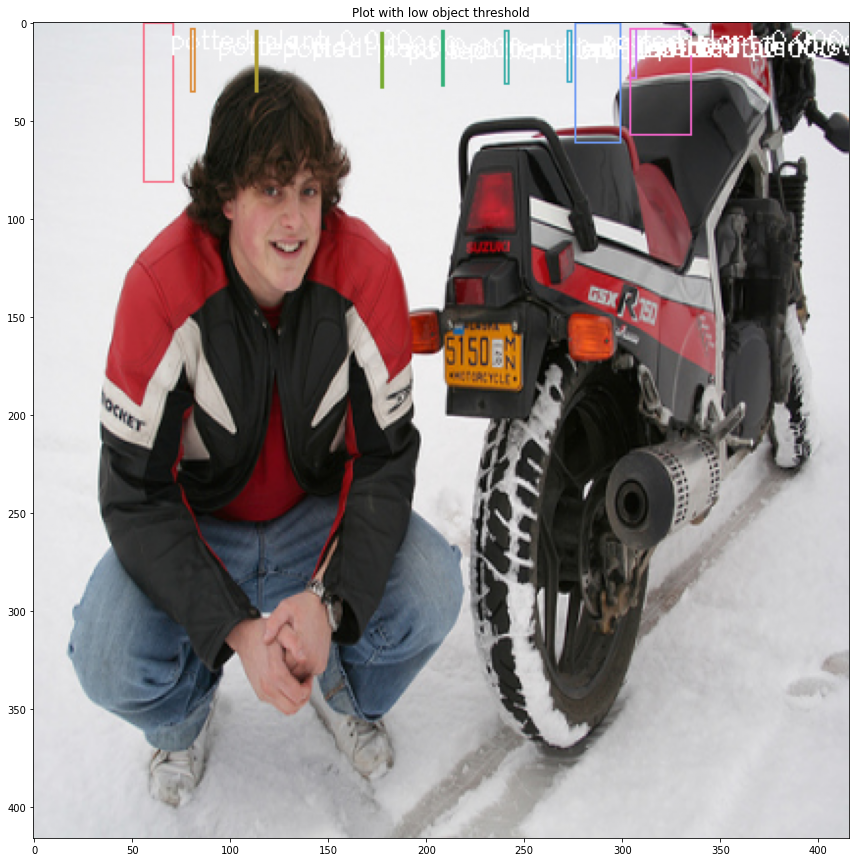

Plot with high object threshold
motorcycle 0.841 xmin= 188,ymin=  12,xmax= 416,ymax= 344
person     0.930 xmin=  20,ymin=  13,xmax= 215,ymax= 398


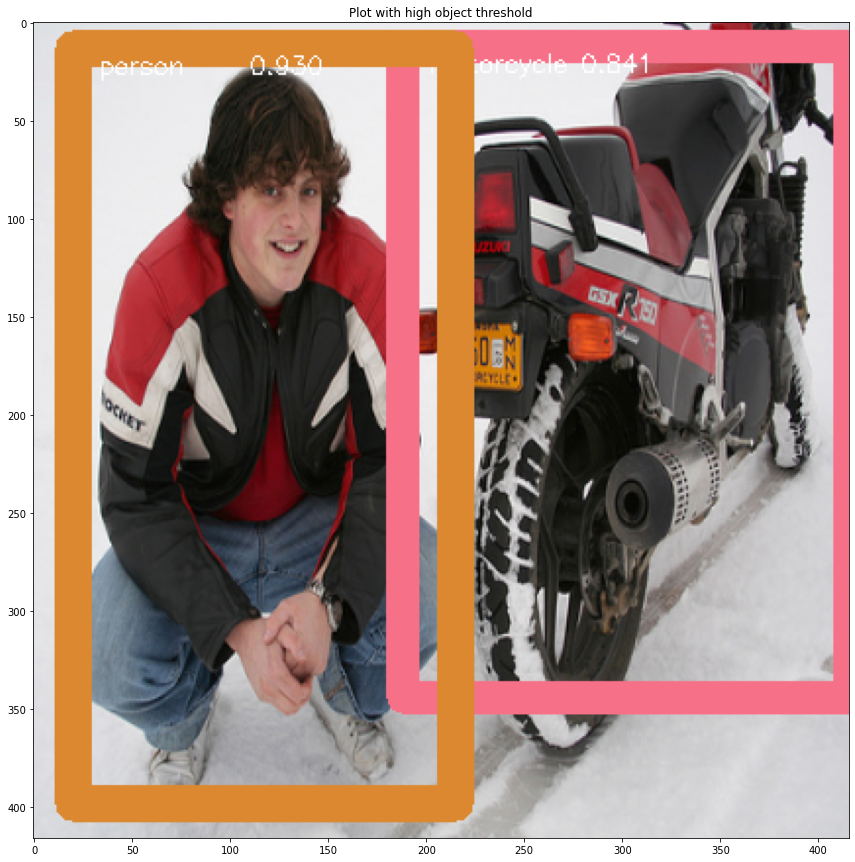

In [50]:
import cv2, copy
import seaborn as sns
def draw_boxes(image, boxes, labels, obj_baseline=0.05,verbose=False):
    '''
    image : np.array of shape (N height, N width, 3)
    '''
    def adjust_minmax(c,_max):
        if c < 0:
            c = 0   
        if c > _max:
            c = _max
        return c
    
    image = copy.deepcopy(image)
    image_h, image_w, _ = image.shape
    score_rescaled  = np.array([box.get_score() for box in boxes])
    score_rescaled /= obj_baseline
    
    colors = sns.color_palette("husl", 10)
    for sr, box,color in zip(score_rescaled,boxes, colors):
        xmin = adjust_minmax(int(box.xmin*image_w),image_w)
        ymin = adjust_minmax(int(box.ymin*image_h),image_h)
        xmax = adjust_minmax(int(box.xmax*image_w),image_w)
        ymax = adjust_minmax(int(box.ymax*image_h),image_h)
 
        
        text = "{:10} {:4.3f}".format(labels[box.label_idx], box.get_score(is_conf=False))
        if verbose:
            print("{} xmin={:4.0f},ymin={:4.0f},xmax={:4.0f},ymax={:4.0f}".format(text,xmin,ymin,xmax,ymax,text))
        cv2.rectangle(image, 
                      pt1=(xmin,ymin), 
                      pt2=(xmax,ymax), 
                      color=color, 
                      thickness=sr)
        
        cv2.putText(img       = image, 
                    text      = text, 
                    org       = (xmin+ 13, ymin + 13),
                    fontFace  = cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale = 1e-3 * image_h,
                    color     = (1, 1, 1),
                    thickness = 1)
        
    return image


print("Plot with low object threshold")
ima = draw_boxes(X_test[0],boxes_tiny_threshold,LABELS,verbose=True)
figsize = (15,15)
plt.figure(figsize=figsize)
plt.imshow(ima); 
plt.title("Plot with low object threshold")
plt.show()

print("Plot with high object threshold")
ima = draw_boxes(X_test[0],boxes,LABELS,verbose=True)
figsize = (15,15)
plt.figure(figsize=figsize)
plt.imshow(ima); 
plt.title("Plot with high object threshold")
plt.show()

In [51]:
def nonmax_suppression(boxes,iou_threshold,obj_threshold):
    '''
    boxes : list containing "good" BoundBox of a frame
            [BoundBox(),BoundBox(),...]
    '''
    bestAnchorBoxFinder    = utils.BestAnchorBoxFinder([])
    
    CLASS    = len(boxes[0].classes)
    index_boxes = []   
    # suppress non-maximal boxes
    for c in range(CLASS):
        # extract class probabilities of the c^th class from multiple bbox
        class_probability_from_bbxs = [box.classes[c]*box.confidence for box in boxes]

        #sorted_indices[i] contains the i^th largest class probabilities
        sorted_indices = list(reversed(np.argsort( class_probability_from_bbxs)))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            # if class probability is zero then ignore
            if boxes[index_i].classes[c] == 0:  
                continue
            else:
                index_boxes.append(index_i)
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    # check if the selected i^th bounding box has high IOU with any of the remaining bbox
                    # if so, the remaining bbox' class probabilities are set to 0.
                    bbox_iou = utils.calculate_iou(boxes[index_i], boxes[index_j])
                    if bbox_iou >= iou_threshold:
                        classes = boxes[index_j].classes
                        classes[c] = 0
                        boxes[index_j].set_class(classes)
    index_boxes = list(set(index_boxes))      
    newboxes = [ boxes[i] for i in index_boxes if boxes[i].get_score(is_conf=False) > obj_threshold ]                

    return newboxes

In [52]:
iou_threshold = 0.6

final_boxes = nonmax_suppression(boxes,iou_threshold=iou_threshold,obj_threshold=obj_threshold)
print("{} final number of boxes".format(len(final_boxes)))

2 final number of boxes


motorcycle 0.841 xmin= 188,ymin=  12,xmax= 416,ymax= 344
person     0.930 xmin=  20,ymin=  13,xmax= 215,ymax= 398


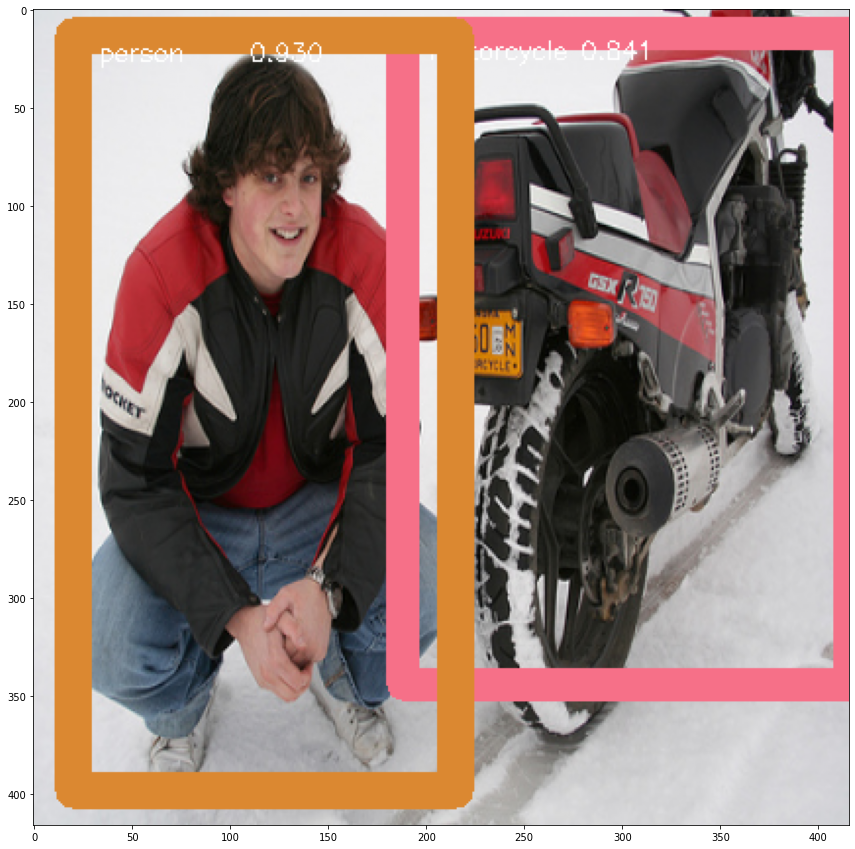

In [53]:
ima = draw_boxes(X_test[0],final_boxes,LABELS,verbose=True)
figsize = (15,15)
plt.figure(figsize=figsize)
plt.imshow(ima); 
plt.show()